# Energy Trends and Modeling
## Jacob Jensen

### Introduction
In the United States, energy consumption and demand is a very critical part of daily lives. Because of this, it is interesting to see the overall annual energy trends but also to try to predict furutre energy trends for an upcoming year. So, with this in mind, this honors project tries to create a higher-order polynomial fit for annual data and trying to apply that to future years, such as 2020.

In [1]:
#Importing the needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

### Data
One of the major parts of the project was to gather the needed data for analysis. What is convenient about the United States energy grid is that there are major power relays in major regions of the United States. One of these includes the Midcontinent Independent System Operator (MISO). Each relay gathers data about inbound and outbound energy, including the MISO, and stores it into an overarching Excel file found here: https://www.eia.gov/beta/electricity/gridmonitor/dashboard/electric_overview/US48/US48. Because this data is so large, it was decided to just focus in on the MISO, as Michigan is within their jurisdiction. The code that handles importing and cleaning data is below. It is noted that the data was converted into a per-day time-scale by averaging the daily values. This allowed for a better curve for the polynomial.

In [22]:
def plotMe(x, yPred, yTrue, title = "NONE", xLabel = "NONE", yLabel = "NONE", save = False):
    """
    Plots out the model and actual data and computes an r^2 score to compare the model with the actual data.
    """
    plt.figure(figsize = (20, 10))
    plt.plot(x, yPred, color = "green", label = "Model Prediction")
    plt.scatter(x, yTrue, color = "red", label = "Actual Data")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend()
    if save == True:
        plt.savefig("{}_vs_{}".format(yLabel, xLabel))
    plt.show()
    plt.figure(figsize = (20, 10))
    plt.title("{} - Residual Plot".format(title))
    plt.scatter(x, yTrue - yPred, color = "purple")
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    if save == True:
        plt.savefig("{}_vs_{}_Residual".format(yLabel, xLabel))
    plt.show()
    print("R^2 Score {:.4f}".format(r2_score(yTrue, yPred)))

def getDailyAvg(hourlyData):
    avgSum = 0
    count = 1
    dailyNetGen = []
    for i in hourlyData:
        if count % 25 == 0:
            count = 1
            dailyNetGen.append(avgSum/24)
            avgSum = 0
        count += 1
        avgSum += i
    return np.array(dailyNetGen)

In [3]:
years = ["2017", "2018", "2019"]
yearlyData = {}

for year in years:
#Reads in all data from files and stores into dataframe.
    DataA = pd.read_csv("EIA930_BALANCE_" + year + "_Jan_Jun.csv", usecols = [0, 1, 2, 5, 6, 7], thousands = ',')
    DataB = pd.read_csv("EIA930_BALANCE_" + year + "_Jul_Dec.csv", usecols = [0, 1, 2, 5, 6, 7], thousands = ',')

    #Sorts to only look at MISO
    DataA = DataA[ DataA["Balancing Authority"] == "MISO" ]
    DataB = DataB[ DataB["Balancing Authority"] == "MISO" ]

    #Creates hour arrays beginning from 0 to the end of the year. Should be 8760
    hours = np.arange(0, 8760, 1)

    #Combine dataframes to make one data frame housing all info
    Data = DataA.append(DataB)
    Data["Year Hours"] = hours
    
    yearlyData[year] = Data
    
    fullData = pd.DataFrame([])
for i in yearlyData:
    yearlyData[i].dropna(inplace = True)
    fullData = fullData.append(yearlyData[i])
fullData["Total Hours"] = np.arange(0, len(fullData["Data Date"]), 1)

Before it was decided to venture into this data, a preliminary plot was captured to see if a higher-order polynomial was suitable for the data. Upon analysis, it was qualitatively confirmed that a higher-order polynomial could be suitable. 

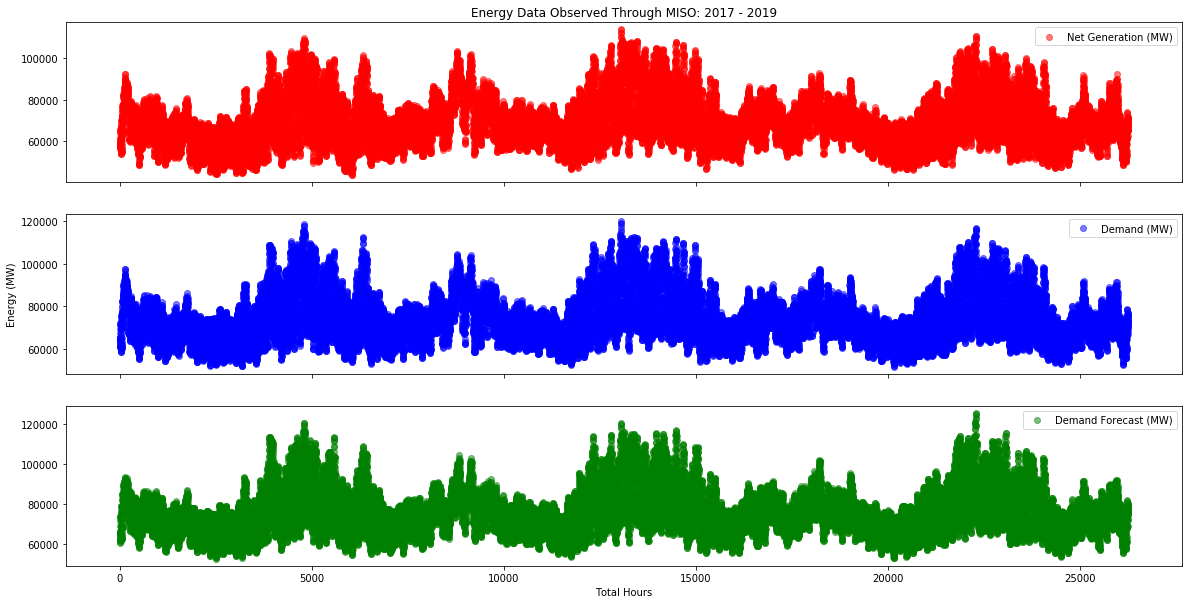

In [23]:
#Plots net gen, demand, and demand forecasted
fig, ax = plt.subplots(3,1, figsize = (20, 10), sharex = True)
ax[0].scatter(fullData["Total Hours"], fullData["Net Generation (MW)"], color = "red", alpha = 0.5)
ax[1].scatter(fullData["Total Hours"], fullData["Demand (MW)"], color = "blue", alpha = 0.5)
ax[2].scatter(fullData["Total Hours"], fullData["Demand Forecast (MW)"], color = "green", alpha = 0.5)
ax[1].set_ylabel("Energy (MW)")
ax[2].set_xlabel("Total Hours")
ax[0].set_title("Energy Data Observed Through MISO: 2017 - 2019")
ax[0].legend(["Net Generation (MW)"])
ax[1].legend(["Demand (MW)"])
ax[2].legend(["Demand Forecast (MW)"])
plt.savefig("OverallTrends")
plt.show()

### Test Data
After it was determined the data was suitable, test data needed to be determined to test the validity of the model. It was decided that the current 2020 data would be used to test the model, as the file is shorter in length and easier to handle. The code to handle importing the data is below:

In [5]:
#Loads in test data
testData = pd.read_csv("EIA930_BALANCE_2020_Jan_Jun.csv", usecols = [0, 1, 2, 5, 6, 7], thousands = ',')
testData = testData[ testData["Balancing Authority"] == "MISO" ]
hours = np.arange(0, len(testData), 1)
testData["Year Hours"] = hours

testData.dropna(inplace = True)

testDataDailyGen = getDailyAvg(testData["Net Generation (MW)"])
testDataDailyDem = getDailyAvg(testData["Demand (MW)"])
testDataDailyForDem = getDailyAvg(testData["Demand Forecast (MW)"])

testDataX = np.arange(0, len(testDataDailyGen), 1)

### Model Creation
With this, a model was created using Numpy's 'polyfit' function. However, even with this, the order is still needed to be determined. This is done by the function below. The function generates a polynomial of best fit with a certain degree and then calculates it's r^2 value. It compiles all the r^2 values it computes for each polynomial and then compares each. It is the nature of higher-order polynomials to increase their r^2 value with increasing order. To vounter this, a difference threshold was determined of 0.03 and so long as the difference in r^2 values is higher than this threshold then the new polynoimal order is accepted. The function returns the best polynomial function for the given data.

In [6]:
#Average out each day to a daily value instead of a hourly value
def getBestPoly(yOrg, maxOrder = 10, thresh = 0.03):
    
    yData = getDailyAvg(yOrg)
    xData = np.arange(0, len(yData), 1)

    #Creates a nth order polynomial to model the over-arching polynomial.
    orderList = []
    r2List = []
    #Loop through all the orders 
    for i in range(maxOrder):
        #Create a polynomial with the certain order
        pfitVal = np.polyfit(xData, yData, i)

        fitFuncPolyGen = np.poly1d(pfitVal)
        predictNext = fitFuncPolyGen(xData)
        
        #Calculate the r^2
        r2 = r2_score(yData, predictNext)
        orderList.append(i)
        r2List.append(r2)
        
    prevDiff = 0
    for i in range(len(r2List)):
        if i < len(r2List) - 1:
            #Calc the difference in r^2
            currDiff = abs(r2List[i+1] - r2List[i])
            #COmparison of r^2 values
            if currDiff > prevDiff and currDiff > thresh:
                bestOrd = orderList[i + 1]
                bestR2 = r2List[i + 1]
            prevDiff = currDiff
    
    #Recalc the best order and return
    pfitVal = np.polyfit(xData, yData, bestOrd)
    fitFuncPoly = np.poly1d(pfitVal)
    return fitFuncPoly, bestOrd

In [28]:
#Create a model for each subset of data.
genFitFunc, genOrd = getBestPoly(yearlyData["2019"]["Net Generation (MW)"])
demFitFunc, demOrd = getBestPoly(yearlyData["2019"]["Demand (MW)"])
demforFitFunc, demforOrd = getBestPoly(yearlyData["2019"]["Demand Forecast (MW)"])

### Plotting
After model creation and r^2 comparison, plots were created for the 2020 upcoming year of data with the model. They can be found within the repository. It is interesting to note that all residual plots look qualitatively random and scattered but the r^2 scores are not

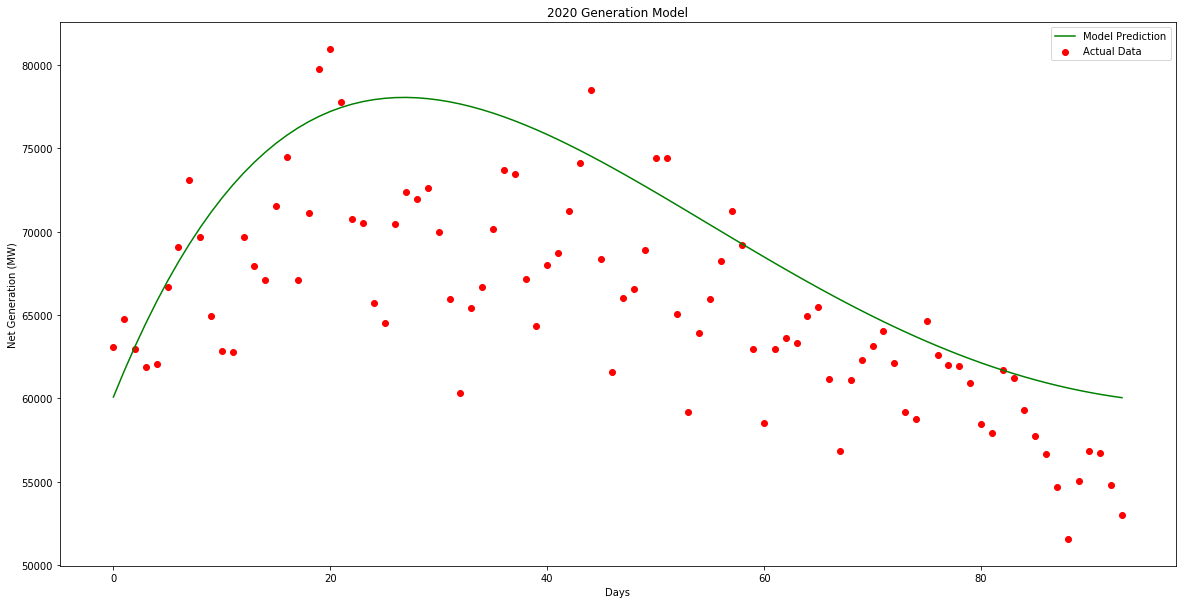

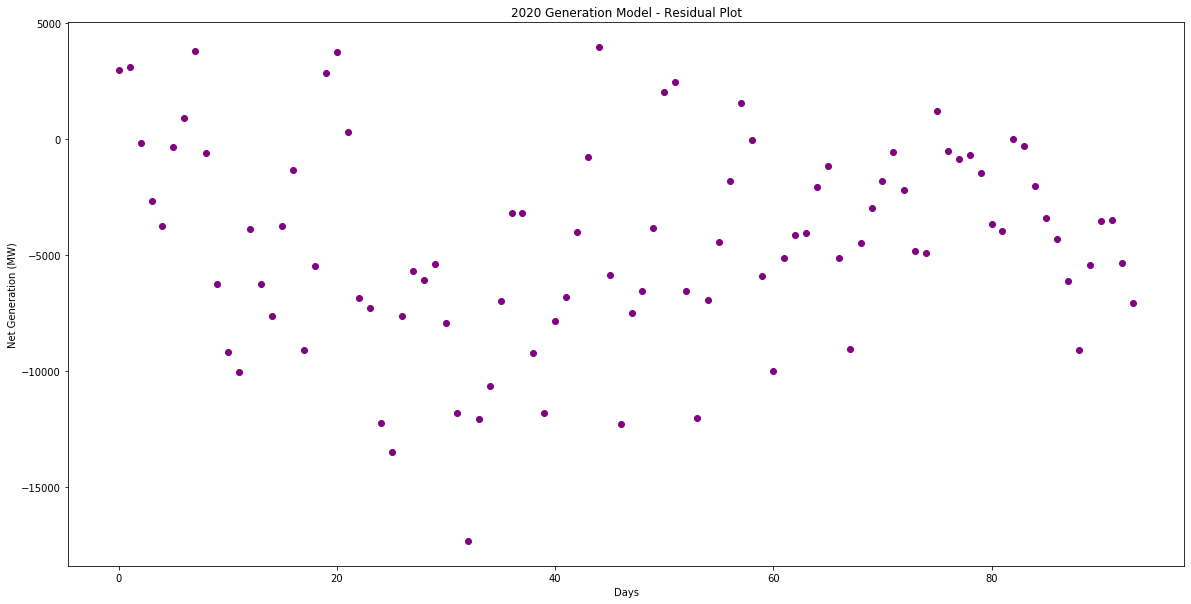

R^2 Score -0.0496


In [29]:
plotMe(testDataX, genFitFunc(testDataX), testDataDailyGen, title = "2020 Generation Model", xLabel = "Days", yLabel = "Net Generation (MW)", save = True)

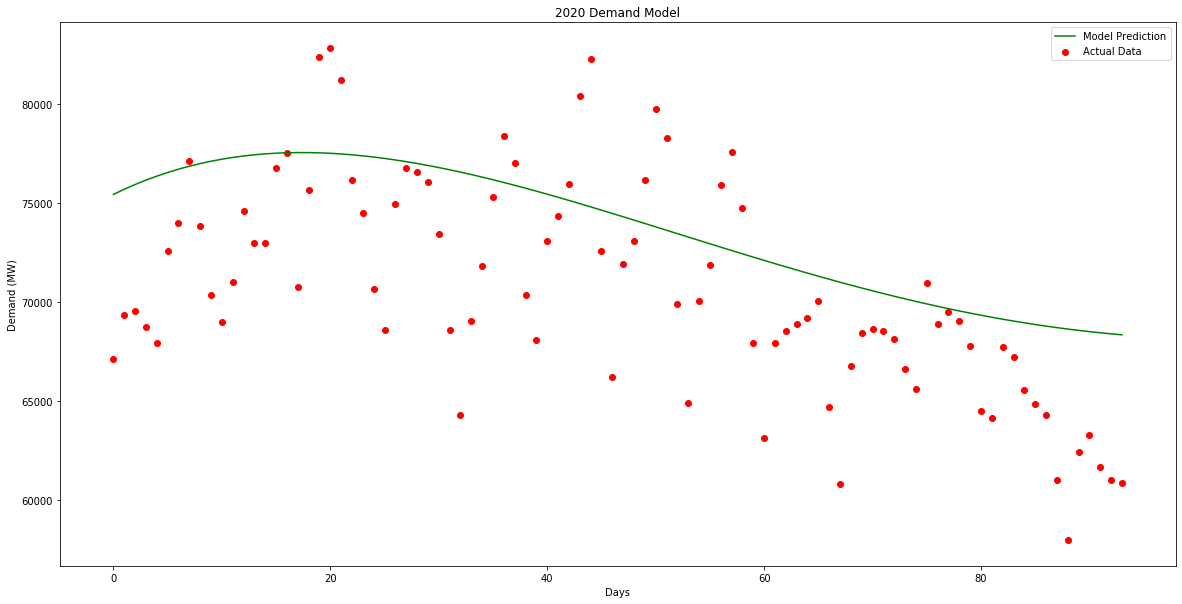

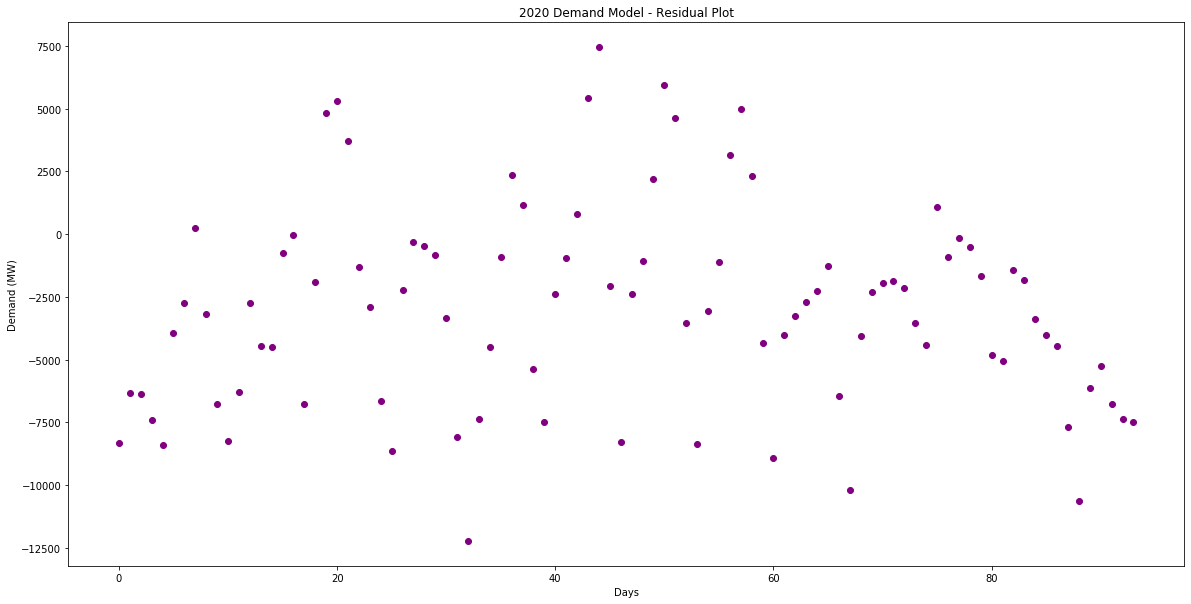

R^2 Score 0.1334


In [30]:
plotMe(testDataX, demFitFunc(testDataX), testDataDailyDem, title = "2020 Demand Model", xLabel = "Days", yLabel = "Demand (MW)", save = True)

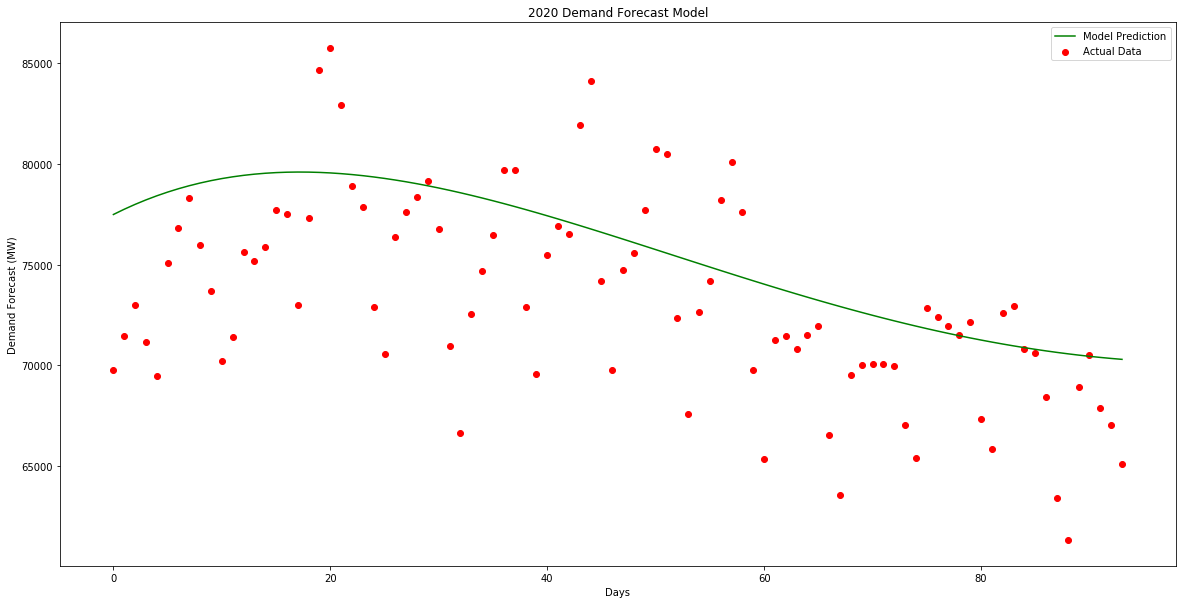

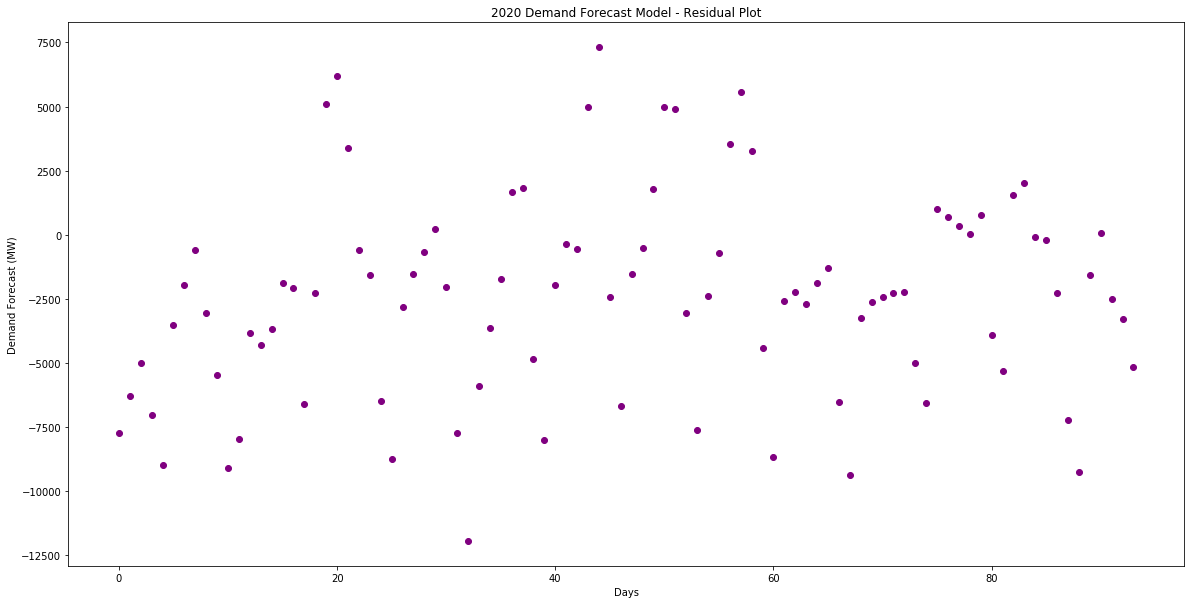

R^2 Score 0.1126


In [31]:
plotMe(testDataX, demforFitFunc(testDataX), testDataDailyForDem, title = "2020 Demand Forecast Model", xLabel = "Days", yLabel = "Demand Forecast (MW)", save = True)

### Conclusions
Once the models were created and their r^2 computed, a qualitative analysis was also done to look at the fit of the model to the data. Although all residual plots for generation, demand, and demand forecast were random, no r^2 value was above 0.2, meaning no model did a very adequate job with modeling the data. However, this does provide insight into the concept that possibly the previous year data is not a good indicator for the upcoming year energy trends and tha tmore factors are at play beyond just the day of the year. To further this model, it would be good to possibly include all available data from 2017-2019 but, due to timing, that was not viable for this project.